In [3]:
import os
#os.environ["TRITON_INTERPRET"] = "1"
import torch
import torch.nn as nn
import triton
from torchtune.modules import RotaryPositionalEmbeddings
import triton.language as tl

torch.manual_seed(0)
device = torch.device("cuda:6")
torch.cuda.set_device(device)


In [4]:
class myRotaryPositionalEmbeddings(nn.Module):
    def __init__(self, dim, max_seq_len=4096, base=10000):
        super().__init__()
        self.dim = dim
        idx = torch.arange(0, dim // 2)[:, None].repeat(1, 4).flatten().contiguous()
        theta = torch.pow(base, -2 * idx / dim)
        m = torch.arange(max_seq_len)
        pos = m[:, None] * theta[None, :]
        pos = pos.reshape(max_seq_len, dim // 2, 2, 2)
        pos[..., 0, 0] = torch.cos(pos[..., 0, 0])
        pos[..., 0, 1] = -torch.sin(pos[..., 0, 1])
        pos[..., 1, 0] = torch.sin(pos[..., 1, 0])
        pos[..., 1, 1] = torch.cos(pos[..., 1, 1])
        pos = pos[None, :, None, :, :, :]
        self.pos = pos.to(device)

    def forward(self, x):
        seq_len = x.size(1)
        x = x.reshape(x.size(0), x.size(1), x.size(2), self.dim // 2, 1, 2)
        pos = self.pos[:, :seq_len]
        #print(pos.size())
        #print(x.size())
        x = pos * x
        x = x.sum(-1)
        #print(x.size())
        x = x.flatten(-2)
        return x
        


In [5]:
x = torch.randn(1, 16, 32, 128).to(device)  # (batch size, seq len, num head, dim)
pos_embed_layer = RotaryPositionalEmbeddings(128, max_seq_len=2**18).to(device)
my_pos_embed_layer = myRotaryPositionalEmbeddings(128, max_seq_len=x.size(1)).to(device) #, #max_seq_len=x.size(1))
y = my_pos_embed_layer(x)
y_ref = pos_embed_layer(x)
print(y.size())
print(y_ref.size())
print(torch.max(torch.abs(y - y_ref)))

torch.Size([1, 16, 32, 128])
torch.Size([1, 16, 32, 128])
tensor(1.4305e-06, device='cuda:6')


print(y.max())
print(y_ref.max())

In [6]:
@triton.jit
def rotate_vector(x_ptr,  # *Pointer* to input vector.
               rot_ptr,  # *Pointer* to rotation matrix
               z_ptr,  # *Pointer* to output vector.
               batch_size: tl.constexpr,
               seq_len, # Sequence length
               embed_dim: tl.constexpr,  # Embedding dimension
               rot_seq_len_stride,  # Sequence length dimension stride for rot
               BLOCK_SIZE: tl.constexpr  # Number of elements each program should process out of sequnce dimension
               ):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    #print(pid)

    # z will have the same offsets and mask as x
    x_start = pid_0 * seq_len * embed_dim + pid_1 * BLOCK_SIZE * embed_dim
    x_offsets = x_start + tl.arange(0, BLOCK_SIZE * embed_dim)
    x_mask = x_offsets < batch_size * seq_len * embed_dim
    
    rot_block_start = pid_1 * BLOCK_SIZE * rot_seq_len_stride
    rot_offsets = rot_block_start + tl.arange(0, BLOCK_SIZE * embed_dim * 2)
    rot_mask = rot_offsets < seq_len * rot_seq_len_stride
    
    x = tl.load(x_ptr + x_offsets, mask=x_mask)
    rot = tl.load(rot_ptr + rot_offsets, mask=rot_mask)
    #print(x.shape)
    #print(rot.shape)
    
    x = tl.reshape(x, (BLOCK_SIZE, embed_dim // 2, 1, 2))
    rot = tl.reshape(rot, (BLOCK_SIZE, embed_dim // 2, 2, 2))
    z = rot * x
    z = tl.sum(z, -1)
    z = tl.reshape(z, (BLOCK_SIZE * embed_dim,))

    tl.store(z_ptr + x_offsets, z, mask=x_mask)

In [7]:
def apply_rope(x: torch.Tensor, rot: torch.Tensor):
    z = torch.empty_like(x)
    batch_size = x.size(0) * x.size(1)
    seq_len = x.size(2)
    embed_dim = x.size(3)
    BLOCK_SIZE = 64
    grid = lambda args: (batch_size, triton.cdiv(seq_len, args['BLOCK_SIZE']))
    kernel = rotate_vector[grid](x, rot, z, batch_size, seq_len, embed_dim, rot.stride(0), BLOCK_SIZE)
    #print(kernel.asm['ttir'])
    return z

In [8]:
x = torch.randn(2, 32, 256, 128).to(device).half()
max_seq_len = x.size(2)
dim = x.size(3)
base = 10000
idx = torch.arange(0, dim // 2)[:, None].repeat(1, 4).flatten().contiguous()
theta = torch.pow(base, -2 * idx / dim)
m = torch.arange(max_seq_len)
pos = m[:, None] * theta[None, :]
pos = pos.reshape(max_seq_len, dim // 2, 2, 2)
pos[..., 0, 0] = torch.cos(pos[..., 0, 0])
pos[..., 0, 1] = -torch.sin(pos[..., 0, 1])
pos[..., 1, 0] = torch.sin(pos[..., 1, 0])
pos[..., 1, 1] = torch.cos(pos[..., 1, 1])
pos = pos.to(device).half()  
#print(pos.size())

output_triton = apply_rope(x, pos)
x = x.transpose(1, 2).contiguous()
output_torch = pos_embed_layer(x).transpose(1, 2)
print(output_torch.size())
print(output_triton.size())

print(f'The mean difference between torch and triton is '
      f'{torch.mean(torch.abs(output_torch - output_triton))}')
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')
print(output_torch == output_triton)
print(output_torch[0, 1])
print(output_triton[0, 1])
#print(output_torch[0, 2] == output_triton[0, 2])

torch.Size([2, 32, 256, 128])
torch.Size([2, 32, 256, 128])
The mean difference between torch and triton is 0.00014221668243408203
The maximum difference between torch and triton is 0.00390625
tensor([[[[ True,  True,  True,  ...,  True,  True,  True],
          [False,  True, False,  ...,  True,  True,  True],
          [False,  True, False,  ...,  True,  True,  True],
          ...,
          [ True,  True,  True,  ...,  True,  True, False],
          [ True, False,  True,  ..., False,  True,  True],
          [ True,  True, False,  ..., False,  True,  True]],

         [[ True,  True,  True,  ...,  True,  True,  True],
          [ True, False, False,  ...,  True,  True,  True],
          [False,  True,  True,  ...,  True,  True,  True],
          ...,
          [ True, False, False,  ...,  True,  True,  True],
          [ True, False,  True,  ...,  True, False,  True],
          [ True,  True, False,  ...,  True,  True, False]],

         [[ True,  True,  True,  ...,  True,  True,  

In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(8, 17, 1)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='rope-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    seq_len = size
    x = torch.rand(4, 32, seq_len, 128, device=device, dtype=torch.float16)
    #print(x.device)
    dim = x.size(3)
    base = 10000
    idx = torch.arange(0, dim // 2)[:, None].repeat(1, 4).flatten().contiguous()
    theta = torch.pow(base, -2 * idx / dim)
    m = torch.arange(seq_len)
    pos = m[:, None] * theta[None, :]
    pos = pos.reshape(seq_len, dim // 2, 2, 2)
    pos[..., 0, 0] = torch.cos(pos[..., 0, 0])
    pos[..., 0, 1] = -torch.sin(pos[..., 0, 1])
    pos[..., 1, 0] = torch.sin(pos[..., 1, 0])
    pos[..., 1, 1] = torch.cos(pos[..., 1, 1])
    pos = pos.to(device).half() 
    
    if provider == 'torch':
        x = x.transpose(1, 2).contiguous()
        ms = triton.testing.do_bench(lambda: pos_embed_layer(x))
    if provider == 'triton':
        #print(x.device)
        ms = triton.testing.do_bench(lambda: apply_rope(x, pos))
    gbps = lambda ms: (2 * x.numel() * x.element_size() + pos.numel() * pos.element_size()) * 1e-9 / (ms * 1e-3)
    return gbps(ms)

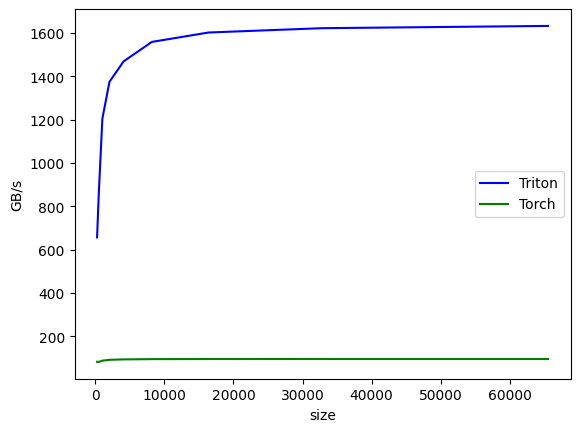

rope-performance:
      size       Triton      Torch
0    256.0   656.540767  82.502589
1    512.0   865.095331  81.727915
2   1024.0  1204.934539  87.719479
3   2048.0  1374.806578  91.410732
4   4096.0  1469.186150  93.425244
5   8192.0  1559.107973  94.653558
6  16384.0  1602.457217  95.101513
7  32768.0  1622.369637  95.251520
8  65536.0  1632.884744  95.255816


In [10]:
benchmark.run(print_data=True, show_plots=True)
